## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3017816/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3017816/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3017816/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3017816/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3017816/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3017816/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3017816/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
import pandas as pd
import time
from tqdm import tqdm
import requests
import json
from pyspark.sql.session import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import time
import matplotlib.pyplot as plt
spark.conf.set('spark.sql.shuffle.partitions','32')
spark.conf.set('spark.sql.adaptive.enabled','true')
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
df = get_source_listing_df()

In [0]:
len(df)
#So there's 20001 source files in total

Out[10]: 200001

In [0]:
show_s3_file_contents('voc_volume/0.json')


Out[11]: b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'

## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
rawSchema = StructType([    
    StructField('date',StringType(),True), 
    StructField('user',StringType(),True), 
    StructField('text',StringType(),True), 
    StructField('sentiment',StringType(),True),
    ]
)

In [0]:
raw_df = (
    spark.readStream
    .schema(rawSchema)
    .json(TWEET_SOURCE_PATH)
)

In [0]:
raw_df = raw_df.withColumn("source_file", input_file_name())
raw_df = raw_df.withColumn("processing_time", current_timestamp())

In [0]:
added_bronze_schema = [StructField('source_file', StringType(), True),
                      StructField('processing_time', TimestampType(), False)]

bronze_defined_schema = StructType(list(rawSchema) + added_bronze_schema)

In [0]:
bronze_stream = (raw_df
                 .writeStream
                 .outputMode("append")
                 .format("delta")
                 .queryName('bronze_stream')
                 .trigger(once=True)
                 .option("checkpointLocation", BRONZE_CHECKPOINT)
                 .start(BRONZE_DELTA)
                )

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
bronze_table = spark.read.format('delta').load(BRONZE_DELTA)

In [0]:
#display(bronze_table)

In [0]:
bronze_table.count()
#A total of 200000 tweets are captured in the Bronze Table

Out[19]: 200000

In [0]:
bronze_table.select([count(when(col(c).isNull(), c)).alias(c) for c in bronze_table.columns]).show()
#This command is used to check number of colums that contain Nan or null values. It seems like none of the columns contain missing value. But if the bronze table contains any missing value, we can simply drop it when constructing the silver table

+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:
count_df = bronze_table.groupby('user').count().orderBy(col('count').desc())
count_df.display()
#This command counts the number of tweets by each unique user and order descendingly


user,count
tweetpet,310
nuttychris,129
iHomeTech,81
tsarnick,77
Hollywood_Trey,71
divxdownloads,68
lesley007,65
redrobinrockn,58
MissxMarisa,57
SarahSaner,56


In [0]:

# Count the tweets have at least one mention
mentioned_tweets = bronze_table.filter(bronze_table["text"].rlike("@."))
mentioned_tweets_count = mentioned_tweets.count()

# Count the tweets have no mentions
no_mentioned_tweets = bronze_table.filter(~bronze_table["text"].rlike("@."))
no_mentioned_tweets_count = no_mentioned_tweets.count()

# Print out the number of count
print("Number of tweets with at least one mention: ", mentioned_tweets_count)
print("Number of tweets with no mention: ", no_mentioned_tweets_count)

Number of tweets with at least one mention:  93803
Number of tweets with no mention:  106197


<Figure size 1152x720 with 0 Axes>

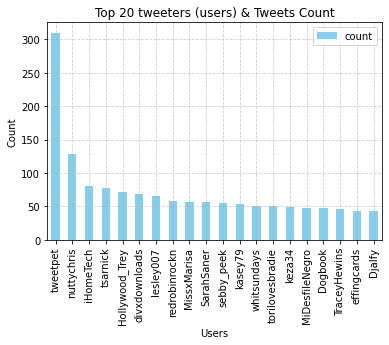

In [0]:

# Retrieve the top 20 tweeters
top_20_tweetuser = count_df.limit(20)
top_20_tweetuser = top_20_tweetuser.toPandas().set_index('user')

# Plot a bar chart that shows the top 20 tweeters (users)
plt.figure(figsize=(16, 10))
top_20_tweetuser.plot(kind='bar', color='skyblue')
plt.title('Top 20 tweeters (users) & Tweets Count')
plt.xlabel('Users')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
#setup a read stream on the bronze delta table
bronze_df = (spark
             .readStream
             .format('delta')            
             .load(BRONZE_DELTA))

In [0]:

transform_silver_df = (bronze_df.withColumn('mention', explode(split(col('text'), " ")))
              .filter(col('mention').rlike(r"^@\w+"))
              .withColumn("mention", regexp_extract(col("mention"), r"@(\w+)", 0))
              .withColumn('cleaned_text', regexp_replace(col('text'), r"@(\w+)", ""))
              .withColumn('cleaned_text', ltrim(col('cleaned_text')))
              .withColumn('timestamp', to_timestamp(col('date'), "EEE MMM dd HH:mm:ss zzz yyyy"))
              .select('timestamp', 'mention', 'cleaned_text', 'sentiment'))

In [0]:
silver_stream = (transform_silver_df
                 .writeStream
                 .format("delta")
                 .outputMode("append")
                 .queryName('silver_stream')
                 .trigger(once=True)
                 .option("checkpointLocation", SILVER_CHECKPOINT)
                 .start(SILVER_DELTA)
                 )

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# A read stream for silver delta
silver_table = (spark
                .readStream
                .format('delta')
                .load(SILVER_DELTA))

In [0]:

import mlflow.pyfunc

model_name = MODEL_NAME
apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

/local_disk0/.ephemeral_nfs/envs/pythonEnv-64b1405e-946d-4f41-b41d-af4f62872ee7/lib/python3.9/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.12.1/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/05/09 15:13:43 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2024/05/09 15:13:50 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.12.1, required: mlflow==2.11.3)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/05/09 15:13:50 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/05/09 15:13:51 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:

predict_df = (silver_table
              .withColumn('predicted', apply_model_udf(col('cleaned_text')))
              .withColumn("predicted_sentiment", col("predicted.label"))
              .withColumn('predicted_score', col('predicted.score'))
              .withColumn('sentiment_id', 
                          when(col('sentiment') == 'positive', 1)
                          .when(col('sentiment') == 'negative', 0))
              .withColumn('predicted_sentiment_id',
                          when(col('predicted_sentiment') == 'POS', 1)
                          .when(col('predicted_sentiment') == 'NEG', 0)
                          .otherwise(-1)
                          )
              .select('timestamp', 'mention', 'cleaned_text', 'sentiment', (col('predicted_score')*100).alias('predicted_score').cast('double'), 'predicted_sentiment', col('sentiment_id').cast('int'), col('predicted_sentiment_id').cast('int'))
              )

In [0]:

gold_stream = (predict_df
               .writeStream
               .format("delta")
               .outputMode("append")
               .queryName('gold_stream')
               .trigger(once=True)
               .option("checkpointLocation", GOLD_CHECKPOINT)
               .start(GOLD_DELTA)
               )

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the mdoel name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:

gold_table = (spark
              .read
              .format('delta')
              .load(GOLD_DELTA))

In [0]:
#From the model, predicted sentiment has three classes positive negative and neutral. But in the original dataset, there's only positive and negative. So I decide to drop all rows with Neutral predicted sentiment
from pyspark.sql.functions import col
gold_table = (gold_table
              .filter(col('predicted_sentiment') != 'NEU')
              .select(['timestamp', 'mention', 'cleaned_text', 'sentiment', 'predicted_score', 'predicted_sentiment', 'sentiment_id', 'predicted_sentiment_id'])
              )

In [0]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
from delta.tables import DeltaTable

y_true = gold_table.select('sentiment_id').collect()
y_pred = gold_table.select('predicted_sentiment_id').collect()

    # Calculate the metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


with mlflow.start_run():
    # Log evaluation metrics
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)

    confusion = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save the confusion matrix plot to a temporary file
    temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    plt.savefig(temp_file.name)
    plt.close()

    mlflow.log_artifact(temp_file.name, artifact_path="confusion_matrix")

    # Store the model's name and model's version as MLflow parameters
    model_name = MODEL_NAME
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("mlflow_version", mlflow.version.VERSION)

    # Store the version of delta table as MLflow parameter
    delta_table = DeltaTable.forPath(spark, SILVER_DELTA)
    delta_version = delta_table.history().orderBy("version").select("version").collect()[-1][0]
    mlflow.log_param("delta_version", delta_version)

    mlflow.end_run()
   

In [0]:
precision

## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

In [0]:
gold_table.count()
#There's a total of 66502 mentions in the gold data

Out[11]: 66502

In [0]:
from pyspark.sql.functions import col, min, max, sum

mention_sentiment = (gold_table
          .groupBy('mention')
          .agg(min('timestamp').alias('min_timestamp'),
               max('timestamp').alias('max_timestamp'),
               sum((gold_table.sentiment == 'negative').cast('int')).alias('negative_count'),
               sum((gold_table.sentiment == 'positive').cast('int')).alias('positive_count'))
          .withColumn('total_count', col('negative_count') + col('positive_count'))
          .select('min_timestamp', 'max_timestamp', 'mention', 'negative_count', 'positive_count', 'total_count')
          )

#display(mention_sentiment)


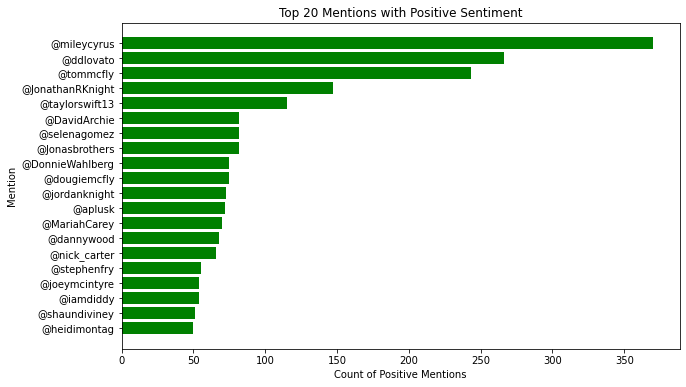

In [0]:
from pyspark.sql import functions as F
top_positive_mentions = mention_sentiment.orderBy(F.desc("positive_count")).limit(20).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_positive_mentions["mention"], top_positive_mentions["positive_count"], color='green')
plt.xlabel("Count of Positive Mentions")
plt.ylabel("Mention")
plt.title("Top 20 Mentions with Positive Sentiment")
plt.gca().invert_yaxis()  # Reverse the y-axis to have the largest bar on top
plt.show()

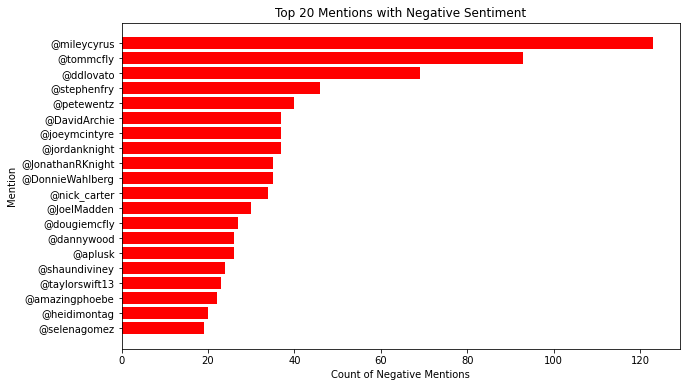

In [0]:
# Step 6: Plot the top 20 mentions with negative sentiment
top_negative_mentions = mention_sentiment.orderBy(F.desc("negative_count")).limit(20).toPandas()
plt.figure(figsize=(10, 6))
plt.barh(top_negative_mentions["mention"], top_negative_mentions["negative_count"], color='red')
plt.xlabel("Count of Negative Mentions")
plt.ylabel("Mention")
plt.title("Top 20 Mentions with Negative Sentiment")
plt.gca().invert_yaxis()  # Reverse the y-axis to have the largest bar on top
plt.show()

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
active_streams = spark.streams.active

# Display detailed information about each active streaming query
for query in active_streams:
    print(f"Query Name: {query.name}")
    print("-------------------------")

In [0]:
stop_all_streams()

Out[18]: False

In [0]:
DA.cleanup()

In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
TOTAL_TIME = END_TIME - START_TIME
print(f'It took {TOTAL_TIME} to run all the notebook')

It took 712.7130763530731 to run all the notebook


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### Spill: I don't observe spill issues during the whole notebook execution
### Skew: Imbalanced data did exist, but streaming and other implementation wasn't being affected a lot.
### Storage: I don't think there's inefficient storage issue exists
### Serialization: Yes, serialization increase the overall running effiency since I set 4 parallel executors at the initialization stage
### Shuffle: Shuffle reading occurs and slows down the implementation of streaming and reading.